In [1]:
# Import everything
from qiskit import QuantumCircuit, Aer, IBMQ, execute, transpile, assemble
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from time import sleep, time
from qiskit.providers.aer.noise import NoiseModel
from operator import attrgetter
# For creating and displaying the GIFs:
from PIL import Image
from IPython.display import Image as IPYImage
from IPython.display import clear_output
import ipywidgets

Let's set some initial parameters:

In [2]:
npix = 64       # No. of pixels in the image
nframes = 15    # No. of frames in animation
theta = 0.45    # Rotation factor (see quantum circuit below)
backend = Aer.get_backend('qasm_simulator')

First we set an initial state for the canvas. The canvas is an array of boolean values (`True` / `False`). I tried two starting patterns: A line of pixels and a random distribution of pixels

In [3]:
pixels = np.zeros((npix,npix), dtype=bool)
# For line pattern:
for i in range(16,48):
    pixels[32][i] = True
# For random pattern:
# density = 0.1
# pixels = np.random.choice(a=[False, True], size=(npix, npix), p=[1-density, density])

We define a function that converts our boolean array into a nice image:

In [4]:
def save_image(pixels, name, frame):
    plt.imsave("frames/%s%i.png" % (name, frame), pixels, cmap="cividis")
    im = Image.open("frames/%s%i.png" % (name, frame))
    im = im.resize((256,256), Image.NEAREST)
    im.save("frames/%s%i.png" % (name, frame))

and check everything works correctly:

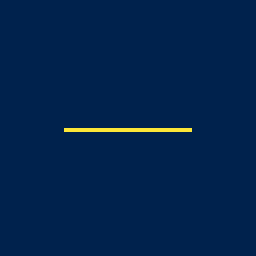

In [5]:
save_image(pixels, 'frame', 0)
IPYImage('frames/frame0.png')

(ooh nice line)

Next we create the quantum circuit that will calculate whether each pixel is `on` or `off`. The first 9 qubits are the input qubits and are set the state of the neighbouring pixel, and the final qubit is that output qubit that we will measure to decide whether our pixel is going to be `on` in the next frame or `off`.

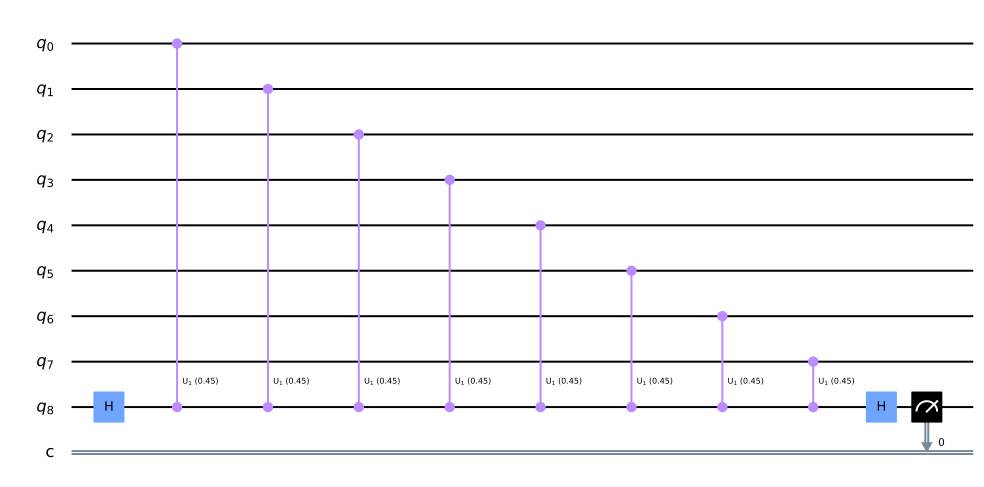

In [6]:
calc_qc = QuantumCircuit(9, 1)
calc_qc.h(8)
for qubit in range(8):
    calc_qc.cu1(theta, qubit, 8)
calc_qc.h(8)
calc_qc.measure(8,0)
calc_qc.draw()

In [7]:
def next_frame(pixels, npix):
    # Make qc for each pixel:
    qc_list = []
    for x in range(npix):
        for y in range(npix):
            # pixel has coordinates (x, y)
            adj_pixels = []  # to store the values of the adjascent pixels
            for d in range(3):
                d -= 1
                # store all values 
                adj_pixels += [pixels[(relx+x-1)%(npix-1)][(y+d)%(npix-1)] for relx in range(3)]
            adj_pixels.pop(4)  # get rid of middle pixel
            qc = QuantumCircuit(9,1)
            # Now set initial values of qubits according to pixel states:
            for i in range(8):
                if adj_pixels[i]:
                    qc.x(i)
            qc += calc_qc  # append calculation circuit to initialisation circuit
            qc_list.append(qc)
    tqc_list = transpile(qc_list, backend, optimization_level=0) # transpile if necessary
    job = execute(tqc_list, backend=backend, shots=1)
    results = job.result()
    new_pixels = np.zeros((npix,npix), dtype=bool)
    for x in range(npix):
        for y in range(npix):
            if '0' in results.get_counts(qc_list.pop(0)):
                new_pixels[x][y] = False
            else:
                new_pixels[x][y] = True
    return new_pixels

Let's run the thing:

In [8]:
save_image(pixels, 'frame', 0)
for frame in range(nframes-1):
    print("%i / " % frame, end="")
    pixels = next_frame(pixels, npix)
    save_image(pixels, 'frame', frame+1)

0 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 

Finally, combine into an image:

In [9]:
def make_gif(gif_name, frame_name, nframes):
    im_list = []
    for frame in range(nframes):
        i = Image.open('frames/%s%i.png' % (frame_name, frame))
        # Rescale image so it's not tiny
        i = i.resize((256,256), Image.NEAREST)
        im_list.append(i)

    im_list[0].save('animations/%s.gif' % gif_name, 
                    save_all=True, 
                    append_images=im_list[1:], 
                    optimize=False, 
                    duration=100, 
                    loop=0)

In [10]:
make_gif("gol_line_%.2f" % theta, "frame", 34)

And display!

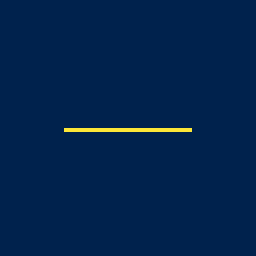

In [11]:
IPYImage('animations/gol_line_%.2f.gif' % theta)